# supplement section 2: Poly PCA and TSNE

Student Name: xiaoyan Huang <br>
Student Id: 22670287 <br>

It is a supplement content for section2. Based on client's requirement, I prefer to go deeper into non-linear pca model and tsne model. Add some new features improves the quality of the model I got before. In addition, I will increase the number of cluster to explore how the model work. 

**content <br>
step1: Feature selection <br>
step2: Polynomial PCA with 4 clusters <br>
step3: TSNE with 5 clusters** <br>

## step1: Feature selection

note: The principle of feature selection is still based on the high correlation, but some element ratio new features such as Al2O3/TiO2, Th/Yb, Nb/Yb, Th/Nb are attempt to add into the model.

In [1]:
import os
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn import preprocessing
from sklearn.cluster import KMeans, SpectralClustering
import plotly
import seaborn as sns
sns.set()
import plotly.express as px
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt

In [2]:
cur_path = os.getcwd()
print("Checking my current path ", cur_path)

Checking my current path  D:\JupyterNotebook\Notebook\Capstone\PCA


In [3]:
path = input("Entering the path you want ")
os.chdir(path) # eg D:\JupyterNotebook\Notebook\Capstone\PCA

Entering the path you want D:\JupyterNotebook\Notebook\Capstone\PCA


In [4]:
filename = input("Entering your filename ")
path_of_ds = os.path.join(path, filename) # eg Kg.csv
dataset = pd.read_csv(path_of_ds,encoding= 'unicode_escape')

Entering your filename Kg.csv


In [5]:
dataset['Rocktype'].unique()

array(['Basalt', 'Dolerite'], dtype=object)

In [6]:
basalt = dataset[dataset['Rocktype'] == 'Basalt']

In [7]:
basalt.shape

(1051, 95)

In [8]:
col = ['aSiO2_pct', 'aTiO2_pct', 'aAl2O3_pct', 'aFe2O3T_pct', 'aMgO_pct', 'aMnO_pct', 'aP2O5_pct', 'Th_ppm', 'Nb_ppm', 'Ta_ppm', 'Zr_ppm', 'Hf_ppm', 'Y_ppm', 'La_ppm', 'Sm_ppm', 'Eu_ppm', 'Gd_ppm', 'Yb_ppm', 'Ni_ppm', 'Cr_ppm', 'Depth (m) from']

In [9]:
X = basalt[basalt.columns & col]

In [10]:
len(X.columns), X.columns

(21,
 Index(['Depth (m) from', 'aSiO2_pct', 'aTiO2_pct', 'aAl2O3_pct', 'aFe2O3T_pct',
        'aMgO_pct', 'aMnO_pct', 'aP2O5_pct', 'Th_ppm', 'Nb_ppm', 'Ta_ppm',
        'Zr_ppm', 'Hf_ppm', 'Y_ppm', 'La_ppm', 'Sm_ppm', 'Eu_ppm', 'Gd_ppm',
        'Yb_ppm', 'Ni_ppm', 'Cr_ppm'],
       dtype='object'))

In [11]:
X.shape

(1051, 21)

In [12]:
X.isnull().sum()

Depth (m) from    249
aSiO2_pct           0
aTiO2_pct           0
aAl2O3_pct          0
aFe2O3T_pct         0
aMgO_pct            0
aMnO_pct            0
aP2O5_pct           0
Th_ppm             14
Nb_ppm             12
Ta_ppm             58
Zr_ppm              0
Hf_ppm             13
Y_ppm               1
La_ppm              0
Sm_ppm              0
Eu_ppm              0
Gd_ppm              0
Yb_ppm              0
Ni_ppm              5
Cr_ppm             21
dtype: int64

note: There are lots of null value in raw dataset due to the limitation of detection. Therefore, these missing values would be replaced by zero. And then, there are some new feature (the ratio for specific chemical elements) created. Furthermore, the denominator should be zero, I have to delete the invalid samples

In [13]:
XX = X.fillna(0)

In [17]:
XX['Al2O3/TiO2'] = XX['aAl2O3_pct']/XX['aTiO2_pct']
XX['Th/Yb'] = XX['Th_ppm']/XX['Yb_ppm']
XX['Nb/Yb'] = XX['Nb_ppm']/XX['Yb_ppm']
XX['Th/Nb'] = XX['Th_ppm']/XX['Nb_ppm']

In [18]:
XX.isnull().sum()

Depth (m) from     0
aSiO2_pct          0
aTiO2_pct          0
aAl2O3_pct         0
aFe2O3T_pct        0
aMgO_pct           0
aMnO_pct           0
aP2O5_pct          0
Th_ppm             0
Nb_ppm             0
Ta_ppm             0
Zr_ppm             0
Hf_ppm             0
Y_ppm              0
La_ppm             0
Sm_ppm             0
Eu_ppm             0
Gd_ppm             0
Yb_ppm             0
Ni_ppm             0
Cr_ppm             0
Al2O3/TiO2         0
Th/Yb              0
Nb/Yb              0
Th/Nb             12
dtype: int64

In [20]:
XX = XX.dropna()
XX.columns, XX.shape

(Index(['Depth (m) from', 'aSiO2_pct', 'aTiO2_pct', 'aAl2O3_pct', 'aFe2O3T_pct',
        'aMgO_pct', 'aMnO_pct', 'aP2O5_pct', 'Th_ppm', 'Nb_ppm', 'Ta_ppm',
        'Zr_ppm', 'Hf_ppm', 'Y_ppm', 'La_ppm', 'Sm_ppm', 'Eu_ppm', 'Gd_ppm',
        'Yb_ppm', 'Ni_ppm', 'Cr_ppm', 'Al2O3/TiO2', 'Th/Yb', 'Nb/Yb', 'Th/Nb'],
       dtype='object'),
 (1039, 25))

## step2: Polynomial PCA with 4 clusters

note: Based on what we did previously, the cluster number is increased from 3 to 4. In this case, we use polynominal model to cluster 4 plausible population groups and evaluate the model's performance.

In [21]:
nor_X = preprocessing.normalize(XX)
pca_poly = KernelPCA(n_components=2, kernel='rbf', gamma=5)
scores_poly = pca_poly.fit_transform(nor_X)

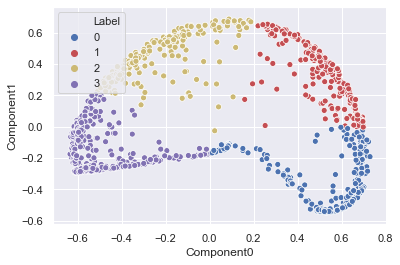

In [22]:
kmeans_pca_poly = KMeans(n_clusters=4, random_state=42)
kmeans_pca_poly.fit(scores_poly)
df_kmeans_pca_poly = pd.concat([XX.reset_index(drop=True), pd.DataFrame(scores_poly)], axis=1)
df_kmeans_pca_poly.columns.values[-2:] = ['Component0','Component1']
df_kmeans_pca_poly['Label'] = kmeans_pca_poly.labels_
x_axis = df_kmeans_pca_poly['Component0']
y_axis = df_kmeans_pca_poly['Component1']
sns.scatterplot(x_axis, y_axis, hue=df_kmeans_pca_poly['Label'], palette = ['b','r','y','m'])

In [23]:
df_kmeans_pca_poly['Dlat'] = basalt['Dlat']
df_kmeans_pca_poly['Dlong'] = basalt['Dlong']
df = df_kmeans_pca_poly
fig = px.scatter_3d(df, x='Dlat', y='Dlong', z='Depth (m) from', color='Label')

In [25]:
print("Saving 3d html in the current path")
filename = os.path.join(path, "3d_fig_poly_4clusters.html")
plotly.offline.plot(fig, filename=filename)

Saving 3d html in the current path


'D:\\JupyterNotebook\\Notebook\\Capstone\\PCA\\3d_fig_poly_4clusters.html'

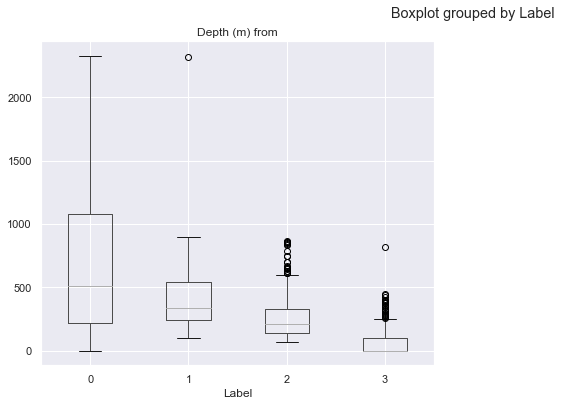

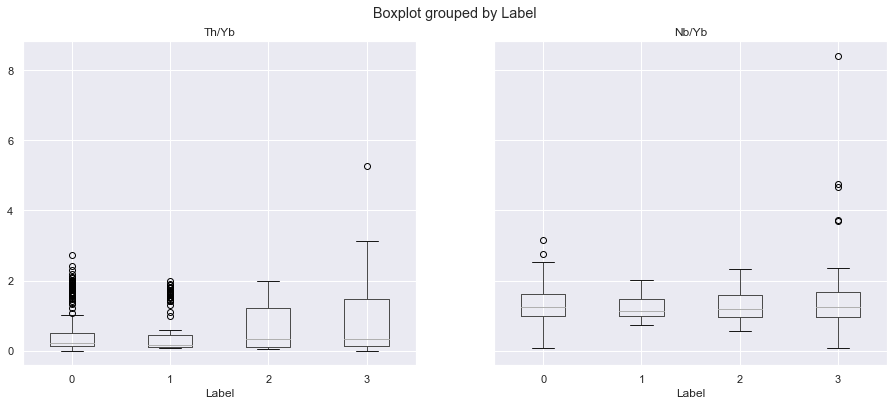

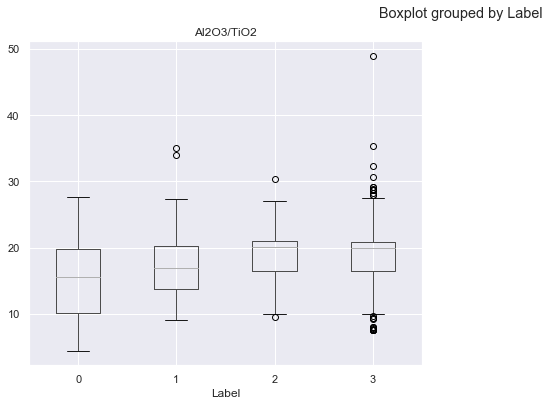

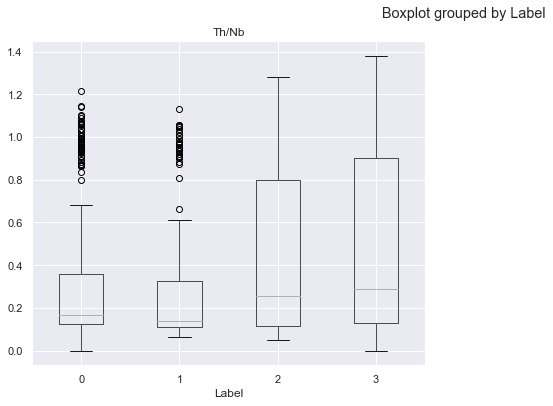

In [26]:
boxplot = df_kmeans_pca_poly.boxplot(column=['Depth (m) from'], by='Label', layout=(1,2), figsize=(15, 6))
boxplot = df_kmeans_pca_poly.boxplot(column=['Th/Yb', 'Nb/Yb'], by='Label', layout=(1,2), figsize=(15, 6))
boxplot = df_kmeans_pca_poly.boxplot(column=['Al2O3/TiO2'], by='Label', layout=(1,2), figsize=(15, 6))
boxplot = df_kmeans_pca_poly.boxplot(column=['Th/Nb'], by='Label', layout=(1,2), figsize=(15, 6))

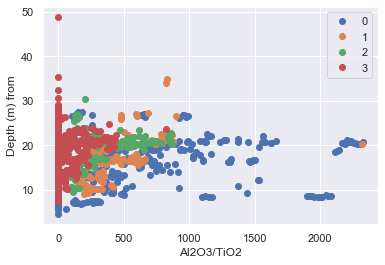

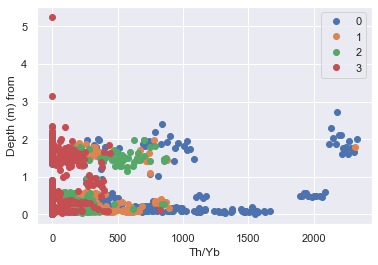

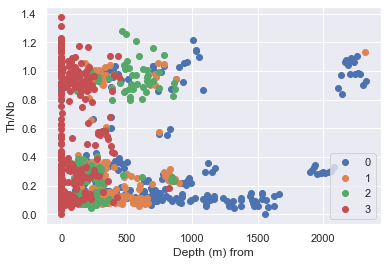

In [27]:
groups = df_kmeans_pca_poly.groupby("Label")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group['Depth (m) from'], group['Al2O3/TiO2'],  marker="o", label=name, linestyle="")
ax.legend()
plt.xlabel('Al2O3/TiO2')
plt.ylabel('Depth (m) from')
plt.show()

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot( group['Depth (m) from'], group['Th/Yb'], marker="o", label=name, linestyle="")
ax.legend()
plt.xlabel('Th/Yb')
plt.ylabel('Depth (m) from')
plt.show()

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group['Depth (m) from'], group['Th/Nb'], marker="o", label=name, linestyle="")
ax.legend()
plt.xlabel('Depth (m) from')
plt.ylabel('Th/Nb')
plt.show()

## step3: TSNE with 5 clusters

note: From the performance of poly model, we can know that it is not available to cluster more than 4 groups. In order to explore more cluster, we change another reduce dimension method called tsne.

In [56]:
pca_tsne = TSNE(n_components=2, init='pca', random_state=0, learning_rate=5, perplexity=100)
scores_tsne = pca_tsne.fit_transform(nor_X)

In [57]:
kmeans_pca_tsne = KMeans(n_clusters=5, random_state=42) 
kmeans_pca_tsne.fit(scores_tsne)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

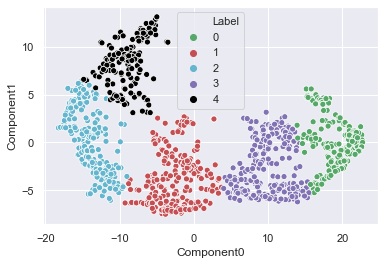

In [58]:
df_kmeans_pca_tsne = pd.concat([XX.reset_index(drop=True), pd.DataFrame(scores_tsne)], axis=1)
df_kmeans_pca_tsne.columns.values[-2:] = ['Component0','Component1']
df_kmeans_pca_tsne['Label'] = kmeans_pca_tsne.labels_
x_axis = df_kmeans_pca_tsne['Component0']
y_axis = df_kmeans_pca_tsne['Component1']
sns.scatterplot(x_axis, y_axis, hue=df_kmeans_pca_tsne['Label'], palette = ['g','r','c','m','black'])

In [59]:
df_kmeans_pca_tsne['Dlat'] = dataset['Dlat']
df_kmeans_pca_tsne['Dlong'] = dataset['Dlong']

df = df_kmeans_pca_tsne
fig = px.scatter_3d(df, x='Dlat', y='Dlong', z='Depth (m) from', color='Label')

In [60]:
print("Saving 3d html in the current path")
filename = os.path.join(path, "3d_fig_tsne_5clusters.html")
plotly.offline.plot(fig, filename=filename)

Saving 3d html in the current path


'D:\\JupyterNotebook\\Notebook\\Capstone\\PCA\\3d_fig_tsne_5clusters.html'

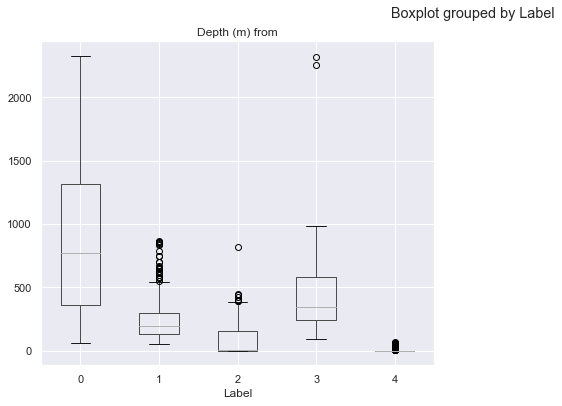

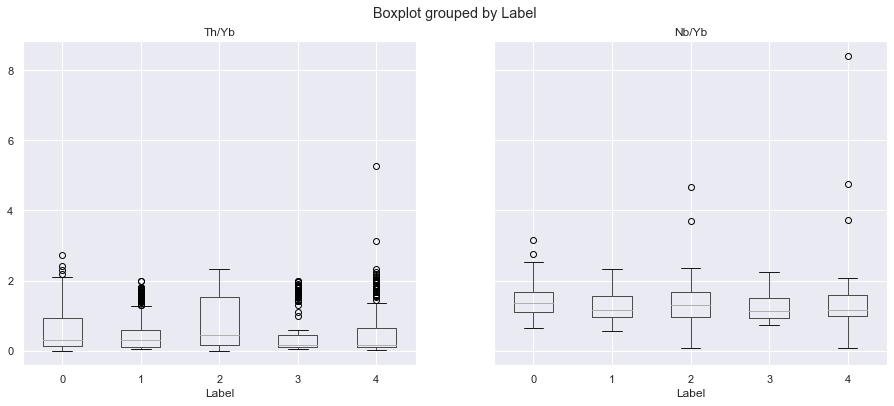

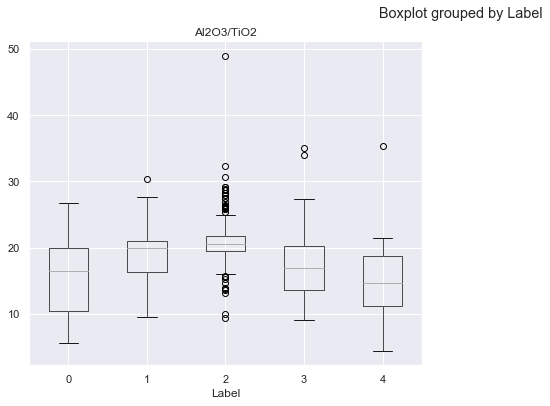

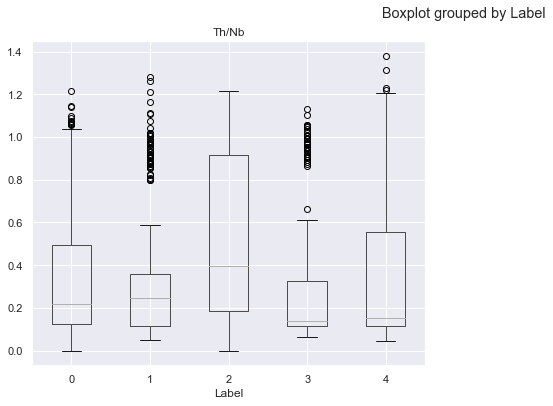

In [61]:
boxplot = df_kmeans_pca_tsne.boxplot(column=['Depth (m) from'], by='Label', layout=(1,2), figsize=(15, 6))
boxplot = df_kmeans_pca_tsne.boxplot(column=['Th/Yb', 'Nb/Yb'], by='Label', layout=(1,2), figsize=(15, 6))
boxplot = df_kmeans_pca_tsne.boxplot(column=['Al2O3/TiO2'], by='Label', layout=(1,2), figsize=(15, 6))
boxplot = df_kmeans_pca_tsne.boxplot(column=['Th/Nb'], by='Label', layout=(1,2), figsize=(15, 6))

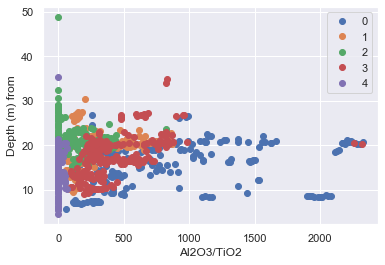

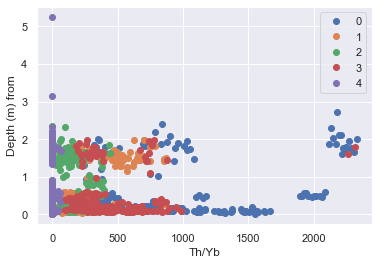

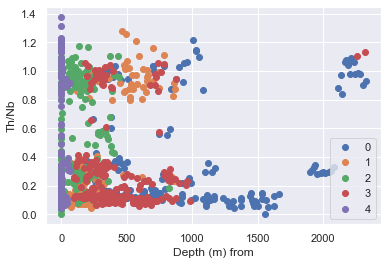

In [62]:
groups = df_kmeans_pca_tsne.groupby("Label")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group['Depth (m) from'], group['Al2O3/TiO2'],  marker="o", label=name, linestyle="")
ax.legend()
plt.xlabel('Al2O3/TiO2')
plt.ylabel('Depth (m) from')
plt.show()

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot( group['Depth (m) from'], group['Th/Yb'], marker="o", label=name, linestyle="")
ax.legend()
plt.xlabel('Th/Yb')
plt.ylabel('Depth (m) from')
plt.show()

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group['Depth (m) from'], group['Th/Nb'], marker="o", label=name, linestyle="")
ax.legend()
plt.xlabel('Depth (m) from')
plt.ylabel('Th/Nb')
plt.show()